In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

## Training and Preprocessing

In [2]:
import numpy as np 
import pandas as pd
import os.path 
from  pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a list with the filepaths for training and testing
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)


2024-03-28 20:20:35.447997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 20:20:35.448285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 20:20:35.650195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['onion' 'apple' 'cucumber' 'cauliflower' 'banana' 'lettuce' 'orange'
 'pear' 'pomegranate' 'cabbage' 'sweetcorn' 'watermelon' 'kiwi' 'paprika'
 'beetroot' 'turnip' 'tomato' 'mango' 'eggplant' 'bell pepper' 'pineapple'
 'raddish' 'corn' 'spinach' 'grapes' 'carrot' 'peas' 'sweetpotato'
 'garlic' 'soy beans' 'ginger' 'potato' 'chilli pepper' 'capsicum'
 'jalepeno' 'lemon']


In [4]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Filepath        Label
0  ../input/fruit-and-vegetable-image-recognition...        onion
1  ../input/fruit-and-vegetable-image-recognition...        apple
2  ../input/fruit-and-vegetable-image-recognition...     cucumber
3  ../input/fruit-and-vegetable-image-recognition...  cauliflower
4  ../input/fruit-and-vegetable-image-recognition...        onion

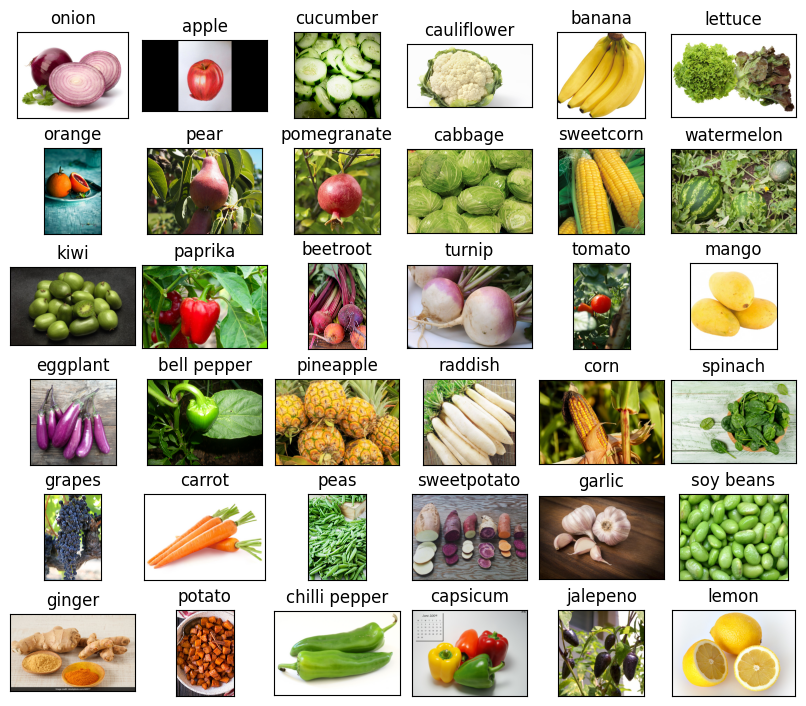

In [5]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## Load the Images with a generator and Data Augmentation

In [6]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [7]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Train the Model

In [8]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(36, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.3640 - loss: 2.5911 - val_accuracy: 0.8443 - val_loss: 0.4902
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8088 - loss: 0.6385 - val_accuracy: 0.9042 - val_loss: 0.3103
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8814 - loss: 0.3671 - val_accuracy: 0.9521 - val_loss: 0.2314
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9380 - loss: 0.2204 - val_accuracy: 0.9521 - val_loss: 0.2000
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9624 - loss: 0.1450 - val_accuracy: 0.9491 - val_loss: 0.2051
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9763 - loss: 0.0972 - val_accuracy: 0.9641 - val_loss: 0.1635
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9767 - loss: 0.0793 - val_accuracy: 0.9521 - val_loss: 0.1774
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9854 - loss: 0.0597 - val_accuracy: 0.9581 - val_loss: 0.

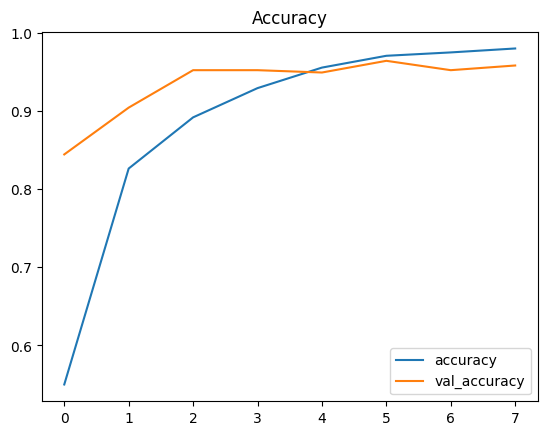

In [9]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

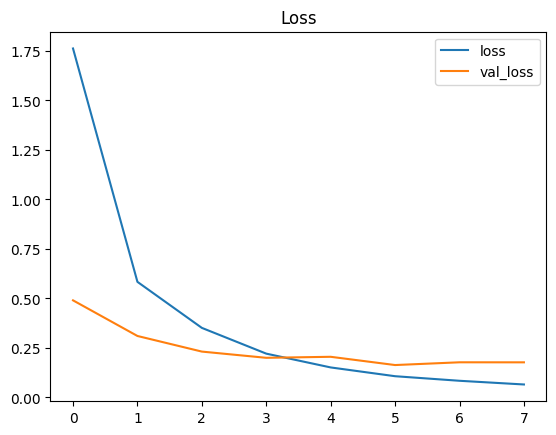

In [10]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [11]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


In [12]:
labels.items()

dict_items([(0, 'apple'), (1, 'banana'), (2, 'beetroot'), (3, 'bell pepper'), (4, 'cabbage'), (5, 'capsicum'), (6, 'carrot'), (7, 'cauliflower'), (8, 'chilli pepper'), (9, 'corn'), (10, 'cucumber'), (11, 'eggplant'), (12, 'garlic'), (13, 'ginger'), (14, 'grapes'), (15, 'jalepeno'), (16, 'kiwi'), (17, 'lemon'), (18, 'lettuce'), (19, 'mango'), (20, 'onion'), (21, 'orange'), (22, 'paprika'), (23, 'pear'), (24, 'peas'), (25, 'pineapple'), (26, 'pomegranate'), (27, 'potato'), (28, 'raddish'), (29, 'soy beans'), (30, 'spinach'), (31, 'sweetcorn'), (32, 'sweetpotato'), (33, 'tomato'), (34, 'turnip'), (35, 'watermelon')])

In [13]:
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 96.41%


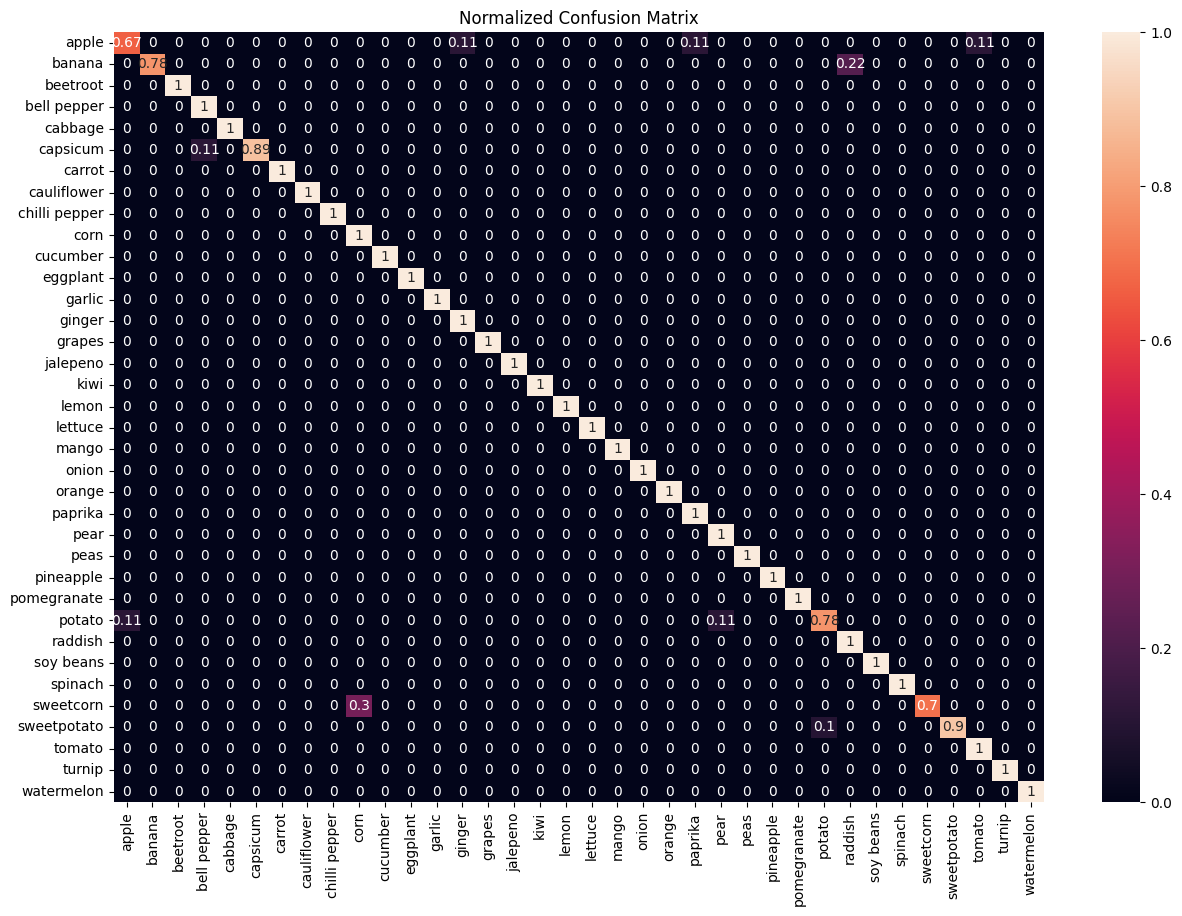

In [14]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

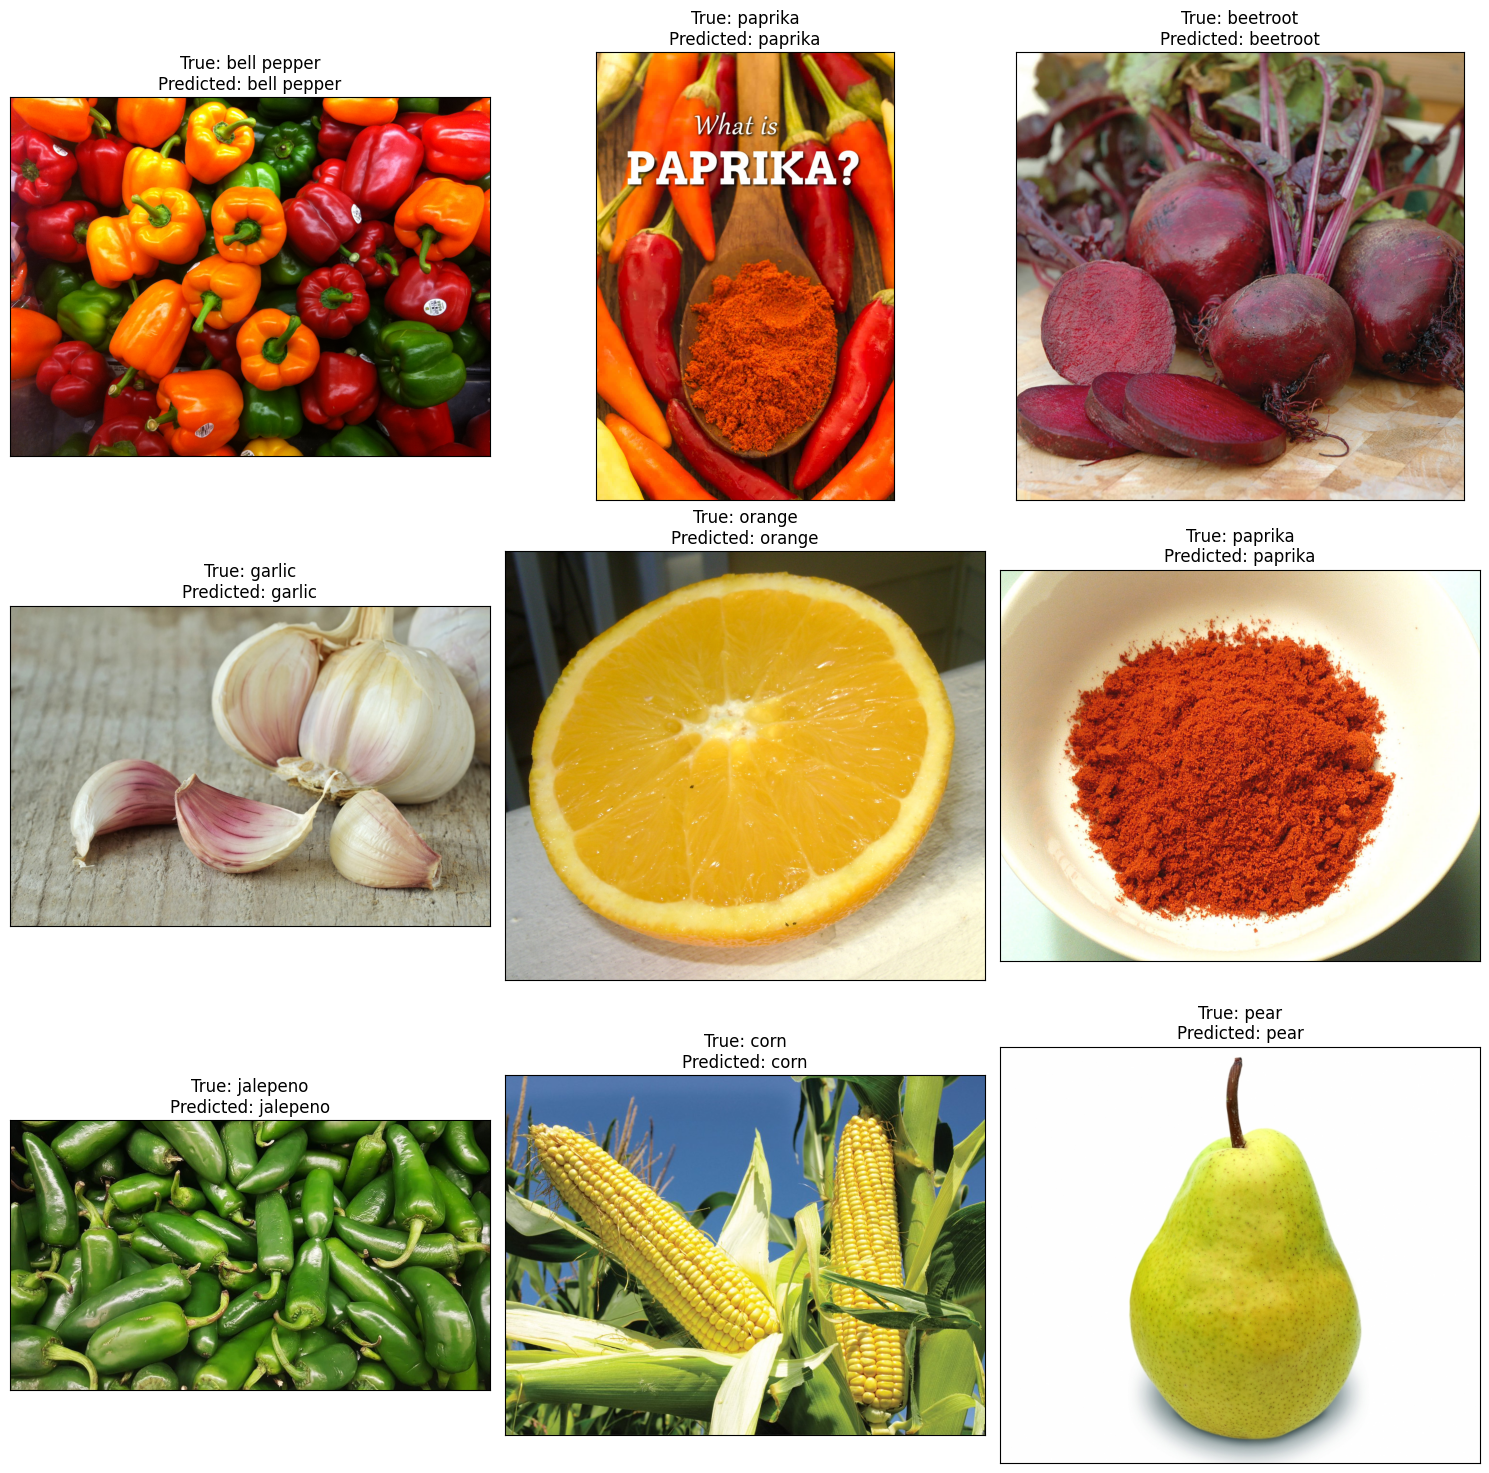

In [15]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [16]:
def output(location):
    from tensorflow.keras.preprocessing.image import load_img,img_to_array
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

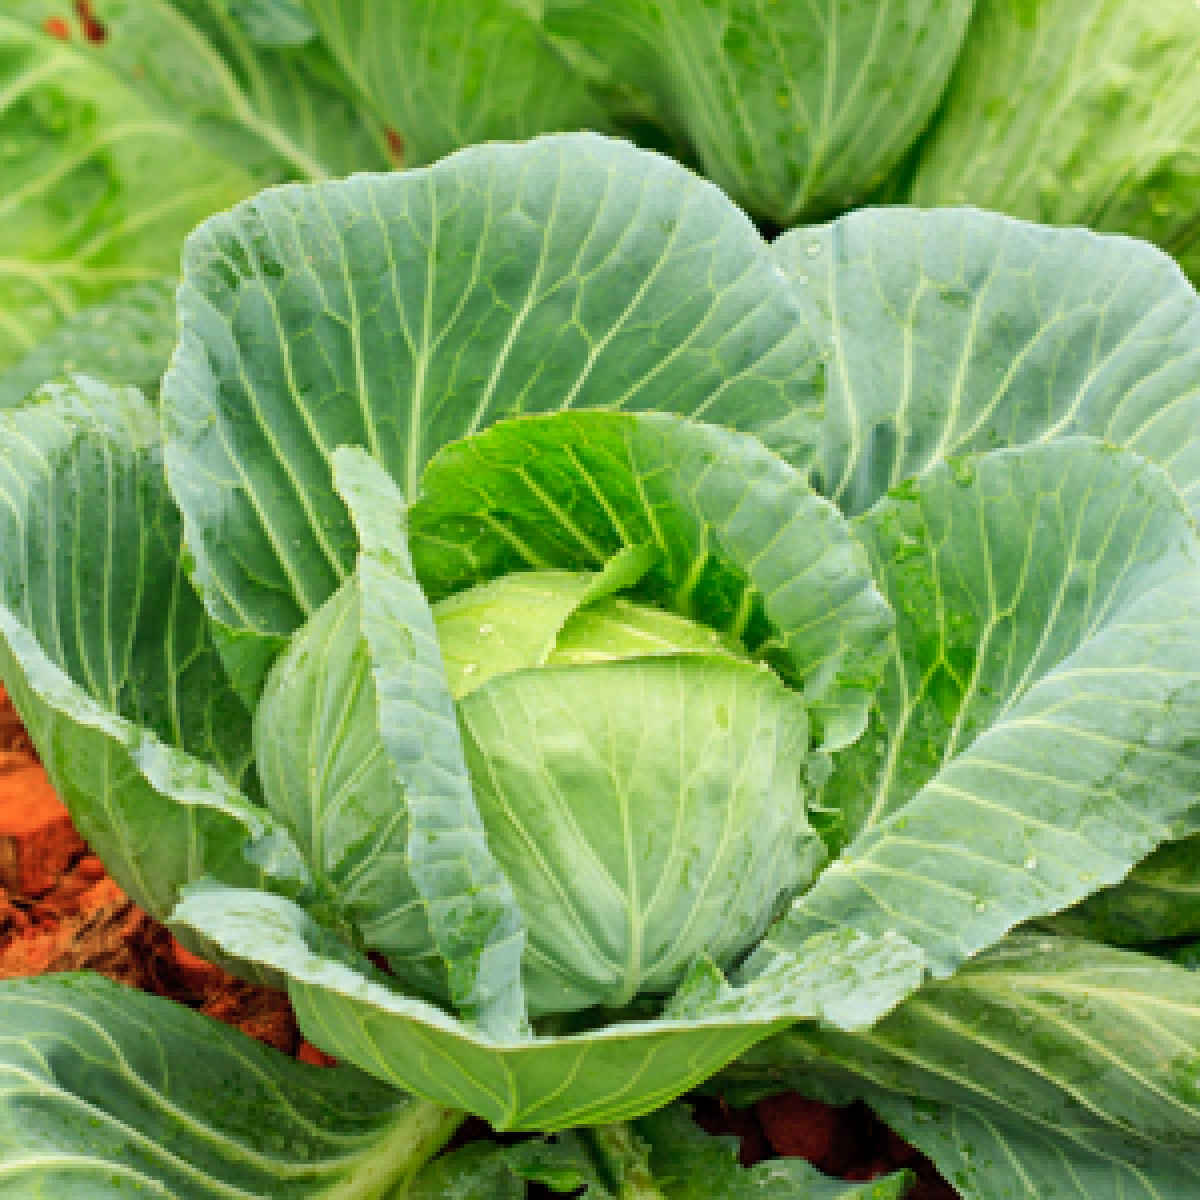

In [17]:
from IPython.display import display
from PIL import Image

location = '../input/fruit-and-vegetable-image-recognition/test/cabbage/Image_5.jpg'
display(Image.open(location))

In [18]:
img = output(location)
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'cabbage'

In [19]:
model.save('FruitModel.h5')